In [10]:
bay = {
    "stack1": [("c1",  4), ("c2", 4)],
    "stack2": [("c3",  1), ("c4", 5)],
    "stack3": [("c5",  5), ("c6", 1), ("c7", 4), ("c8", 1)],
    "stack4": [("c9",  2), ("c10", 5), ("c11", 3)],
    "stack5": [("c12", 3), ("c13", 2)]
}

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from matplotlib import cm

In [12]:
#Functions
def calculate_u_c(bay, container):
    # Get the stack and the index of the container
    stack, index = get_container_position(bay, container)
    if index is None or index == 0:  # If the container is not in the stack or it's at the bottom
        return float('inf')
    else:
        return min(c[1] for c in bay[stack][:index])  # Return the smallest time frame of the containers below

def get_container_time(bay, container):
    for stack in bay.values():
        for c, t in stack:
            if c == container:
                return t
    return None

    # Function to get container position
def get_container_position(bay, container_id):
    for stack_name, stack in bay.items():
        for position, (id, _) in enumerate(stack):
            if id == container_id:
                return stack_name, position
    return None, None

def calculate_q_values(bay):
    # Initialize q_values dictionary
    q_values = {stack_name: [] for stack_name in bay.keys()}

    # Calculate q(c) for each container in the bay
    for stack_name, stack in bay.items():
        for i, container in enumerate(stack):
            if i == 0:  # no container underneath
                u_c = float('inf')  # assign it to infinity
            else:
                u_c = min(time_window for _, time_window in stack[:i])  # Smallest time frame of containers underneath c

            t_c = container[1]  # t(c) is the time window of the container
            if u_c > t_c:
                q_c = 1
            elif u_c == t_c:
                q_c = 2
            elif u_c > min_h_s(bay) or t_c < max_l_s(bay):
                q_c = 3
            else:
                q_c = 4

            # Add to q_values
            q_values[stack_name].append(q_c)
    return q_values

def calculate_expected_relocation_moves(bay):
    # Calculate q_values
    q_values = calculate_q_values(bay)

    # Calculate and return the total expected relocation moves for the entire bay
    return sum(1.4 if q_c == 4 else 1 if q_c == 3 else 0.5 if q_c == 2 else 0 
               for stack_name in bay.keys() 
               for q_c in q_values[stack_name])

def calculate_expected_moves(bay, stack):
    # Calculate q_values
    q_values = calculate_q_values(bay)
    # Calculate and return the expected moves for a stack
    return sum(1.4 if q_c == 4 else 1 if q_c == 3 else 0.5 if q_c == 2 else 0 for q_c in q_values[stack])

# Functions to compute the minimum of the largest time frames and the maximum of the smallest time frames
#def min_h_s(bay):
#    return min(max(time_window for _, time_window in stack) for stack in bay.values())

#def max_l_s(bay):
#    return max(min(time_window for _, time_window in stack) for stack in bay.values())

def min_h_s(bay):
    return min(max(time_window for _, time_window in stack) if stack else 0 for stack in bay.values())

def max_l_s(bay):
    return max(min(time_window for _, time_window in stack) if stack else 0 for stack in bay.values())


def plot_bay(bay):
    fig, ax = plt.subplots()

    colors = ['cyan', 'lightgreen', 'yellow', 'pink', 'orange']  # add more colors if needed

    for i, (stack_name, stack) in enumerate(bay.items()):
        bottom = 0
        for j, (container_id, container_time) in enumerate(stack):
            ax.bar(i, 1, bottom=bottom, color=colors[container_time - 1], edgecolor='black', width=1)
            ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
            bottom += 1

    ax.set_xticks(np.arange(len(bay)))
    ax.set_xticklabels(bay.keys())

    # Setting y ticks as 'Tier 1', 'Tier 2', etc.
    ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
    ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

    # Removing x-axis ticks for a cleaner look
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)  # labels along the bottom edge are off

    ax.set_xlim(left=-0.5)  # adjust the x-axis limit to remove the gap
    plt.show()
    
def get_smallest_time_frame(stack):
    return min([c[1] for c in stack])

def get_containers_below(bay, container):
    # Get the stack of the container
    stack = next((stack for stack, containers in bay.items() if any(c[0] == container for c in containers)), None)
    # Get the position of the container in the stack
    container_position = next((index for index, c in enumerate(bay[stack]) if c[0] == container), None)
    # Get all the containers below the specified container in the stack
    containers_below = [c[0] for index, c in enumerate(bay[stack]) if index < container_position]
    return containers_below

def is_correctly_placed(bay, container_c):
    # Identify the current stack of the container c (s_c) and its position (p_c)
    s_c, p_c = get_container_position(bay, container_c)
    t_c = get_container_time(bay, container_c)  # get the time window of the container c

    # Get all the containers below c in stack s_c
    containers_below_c = get_containers_below(bay, container_c)

    # Check if all containers below c have a larger time frame
    for container in containers_below_c:
        if get_container_time(bay, container) <= t_c:
            return False  # c is incorrectly placed

    return True  # If all conditions are met, c is correctly placed

In [13]:
def select_stack_for_relocation(bay, exclude_stacks, c_prime, t_c_prime, α, λ1, λ2, H):
    # If there exists a stack s' in S \ exclude_stacks for which n(s') < H and l(s') > t(c') and f(B, s') <= α
    available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks and get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]
    #whithout alpha
    #available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks and get_smallest_time_frame(stack) > t_c_prime ]

    if available_stacks:
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        # Select λ1 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ1]
    else:
        # If no valid stacks, select one with the smallest minimum time frame
        available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks]
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        # Select λ2 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ2]

    # Select a stack randomly
    if selected_stacks:  # Check if the list is not empty
        s_double_prime = random.choice(selected_stacks)
    else:
        s_double_prime = None
    print('available stack for relocation : ', available_stacks)
    print('lambda_2 selected stack for relocation : ',selected_stacks)
    print('s_double_prime: ', s_double_prime)
    return s_double_prime

def select_stack_for_c(bay, s_c, H):
    # Find the available stacks for moving container c
    available_stacks = [s for s in bay.keys() if s != s_c and len(bay[s]) < H]
    
    # If no stacks are available, return None
    if not available_stacks:
        return None

    # Find the stack with the highest number of containers
    highest_stack = max(available_stacks, key=lambda s: len(bay[s]))
    print('available stack for c : ', available_stacks)
    print('highest stack for c : ',highest_stack)
    return highest_stack

In [14]:
def preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H):
    print("====================")
    print('algorithm 4 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    S1 = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    print('S1:', S1)
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and not is_correctly_placed(bay, c[0])}
    S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and get_container_time(bay,c[0])<t_c}

    print('S2:' ,S2)
    
    
    while S1:
        print('==for S1== ')
        c_prime = max(S1, key=S1.get) #top container
        t_c_prime = get_container_time(bay, c_prime) #get time of the container

        # Select s'' for relocation
        excluded_stacks=s_c
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [],bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S1
        P.append((s_c, s_double_prime))
        S1.pop(c_prime)
    
    print("==for c==")
    # Move container c to the highest stack s''' with n (s''') < H
    stack_triple_prime = select_stack_for_c(bay, s_c, H)
    print('available stack for temporary relocation of c: ', stack_triple_prime)
    if stack_triple_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
        return [],bay
    bay_copy[stack_triple_prime].append((container_c, t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]  # remove container c from the stack
    P.append((s_c, stack_triple_prime))
    
    
    while S2:
        print('==for S2== ')
        c_prime = max(S2, key=S2.get)
        t_c_prime = get_container_time(bay, c_prime)
        # Select s'' for relocation
        excluded_stacks=[s_c,stack_triple_prime]
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [],bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S2
        P.append((s_c, s_double_prime))
        S2.pop(c_prime)

    # Move container c to stack s
    bay_copy[s_c].append((container_c, t_c))
    bay_copy[stack_triple_prime] = [c for c in bay_copy[stack_triple_prime] if c[0] != container_c]
    P.append((stack_triple_prime, s_c))

    return P, bay_copy


# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and stack
container_c = 'c4'
#stack_s = 'stack3'

# Define α, λ1, λ2, H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Test Algorithm 4
P, bay = preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 4 is used
S1: {}
S2: {'c3': 0}
==for c==
available stack for c :  ['stack1', 'stack3', 'stack4', 'stack5']
highest stack for c :  stack3
available stack for temporary relocation of c:  stack3
==for S2== 
available stack for relocation :  ['stack1', 'stack5']
lambda_2 selected stack for relocation :  ['stack5', 'stack1']
s_double_prime:  stack5
The pre-processing moves: [('stack2', 'stack3'), ('stack2', 'stack5'), ('stack3', 'stack2')]
The updated bay: {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2), ('c3', 1)]}


In [15]:
def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            c_prime = m
            M_c.pop(c_prime)
            p_1 = stack_s
        else:
            c_prime = o
            O_c.pop(c_prime)
            p_1 = s_c

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [], bay
        
        if s_double_prime is not None:
            bay_copy[s_double_prime].append((c_prime, t_c_prime))
            bay_copy[p_1] = [c for c in bay_copy[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))

    # Move container c to the destination stack and update the bay
    bay_copy[stack_s].append((container_c,t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))

    return P, bay_copy
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and destination stack
container_c = 'c4'
stack_s = 'stack1'

# Define α, λ1, λ2, H3
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Apply Algorithm 3
P, bay = preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 3 is used
Set O_c: {}
Set M_c: {'c1': 0, 'c2': 1}
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 selected stack for relocation :  ['stack3', 'stack4', 'stack5']
s_double_prime:  stack5
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 selected stack for relocation :  ['stack3', 'stack4', 'stack5']
s_double_prime:  stack3
The pre-processing moves: [('stack1', 'stack5'), ('stack1', 'stack3'), ('stack2', 'stack1')]
The updated bay: {'stack1': [('c4', 5)], 'stack2': [('c3', 1)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1), ('c1', 4)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2), ('c2', 4)]}


In [16]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

In [17]:
calculate_q_values(bay)

{'stack1': [1, 2],
 'stack2': [1, 4],
 'stack3': [1, 1, 4, 2],
 'stack4': [1, 4, 3],
 'stack5': [1, 1]}

In [18]:
calculate_expected_relocation_moves(bay)

6.199999999999999

In [19]:
# Determine the maximum time frame Z in the bay


In [20]:
def is_correctly_placed(bay, container_c):
    # Identify the current stack of the container c (s_c) and its position (p_c)
    s_c, p_c = get_container_position(bay, container_c)
    t_c = get_container_time(bay, container_c)  # get the time window of the container c

    # Get all the containers below c in stack s_c
    containers_below_c = get_containers_below(bay, container_c)

    # Check if all containers below c have a larger time frame
    for container in containers_below_c:
        if get_container_time(bay, container) <= t_c:
            return False  # c is incorrectly placed

    return True  # If all conditions are met, c is correctly placed

bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}
Z= max(time for stack in bay.values() for _, time in stack)


import random
for p in range(Z, 0, -1):
        # Get the containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print(A_p)
        
        for _ in range(len(A_p)):
            # Create a list of all containers in A_p that are not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print('incorrectly placed :',incorrectly_placed_containers )
            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                print('selected incorrectly container:', c)


                A_p.remove(c)

{'c4', 'c5', 'c10'}
incorrectly placed : ['c4', 'c10']
selected incorrectly container: c10
incorrectly placed : ['c4']
selected incorrectly container: c4
incorrectly placed : []
{'c7', 'c2', 'c1'}
incorrectly placed : ['c7', 'c2']
selected incorrectly container: c7
incorrectly placed : ['c2']
selected incorrectly container: c2
incorrectly placed : []
{'c12', 'c11'}
incorrectly placed : ['c11']
selected incorrectly container: c11
incorrectly placed : []
{'c13', 'c9'}
incorrectly placed : []
incorrectly placed : []
{'c8', 'c3', 'c6'}
incorrectly placed : ['c8']
selected incorrectly container: c8
incorrectly placed : []
incorrectly placed : []


In [21]:
A_p

{'c3', 'c6'}

In [22]:
import copy
def local_search_heuristic(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    best_bay=copy.deepcopy(bay)
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get he containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)

            best_improvement = 0
            best_stack = None
            #best_bay = None
            best_bay=copy.deepcopy(bay)
            best_moves = []

            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                # Create a copy of the current bay configuration
                #bay_copy = bay.copy()
                bay_copy = copy.deepcopy(bay)

                print('bay copy: ',bay_copy)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, bay_copy = preprocessing_moves_algo3(bay_copy, c, s, α, λ1, λ2, H)
                else:
                    pre_moves, bay_copy = preprocessing_moves_algo4(bay_copy, c, α, λ1, λ2, H)

                #if pre_moves is None or bay_copy is None:  # If the move was not feasible, skip to the next iteration
                if not pre_moves:  # If the move was not feasible, skip to the next iteration
                    continue
                    
                print('pre-moves for ',s,' stack :', pre_moves)
                print('new Bay orientation for ',s,' stack :', bay_copy)
                print('original Bay orientation for ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(bay_copy)
                m_s = len(pre_moves)
                #improvement = current_moves - (α * m_s + new_moves)
                improvement = current_moves -  new_moves

                # Update the best improvement and the best destination stack
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_stack = s
                    best_bay = bay_copy
                    best_moves = pre_moves
                    print("*** improvement achieved***")
                    print("best moves: ", best_moves)
                    print("best bay :", best_bay)
            # If the best improvement is positive, update the bay configuration and the pre-processing moves
            if best_improvement >= 0:
                bay = best_bay
                P += best_moves

    return P,best_bay




In [23]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 5
Containers in  5 time window : {'c4', 'c5', 'c10'}
####################
incorrectly_placed_containers   5 time window : ['c4', 'c10']
Target Container in 5  time window : c10
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
bay:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
algorithm 3 is used
Set O_c: {'c11': 2}
Set M_c: {'c1': 0, 'c2': 1}
available stack for relocation :  ['stack2', 'stack5']
lambda_2 selected stack for relocation :  ['stack2', 'stack5']
s_double_prime:  stack2
available stack for relocation :  ['stack2', 'stack5']
lambda_2 selected stack for relocati

In [24]:
bay

{'stack1': [('c1', 4), ('c2', 4)],
 'stack2': [('c3', 1), ('c4', 5)],
 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)],
 'stack5': [('c12', 3), ('c13', 2)]}

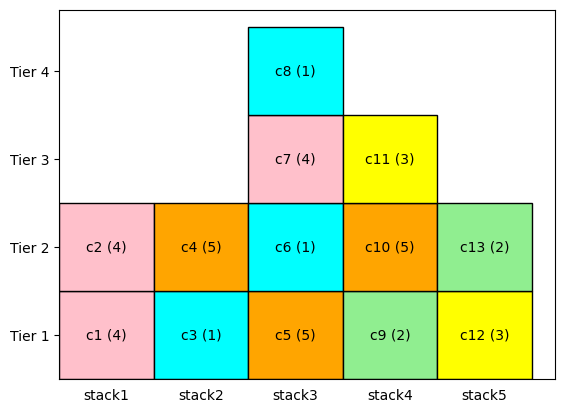

In [25]:
plot_bay(bay)

In [26]:
updated_bay

{'stack1': [('c1', 4), ('c3', 1)],
 'stack2': [('c10', 5), ('c7', 4), ('c11', 3)],
 'stack3': [('c5', 5), ('c4', 5), ('c2', 4)],
 'stack4': [('c9', 2), ('c8', 1)],
 'stack5': [('c12', 3), ('c13', 2), ('c6', 1)]}

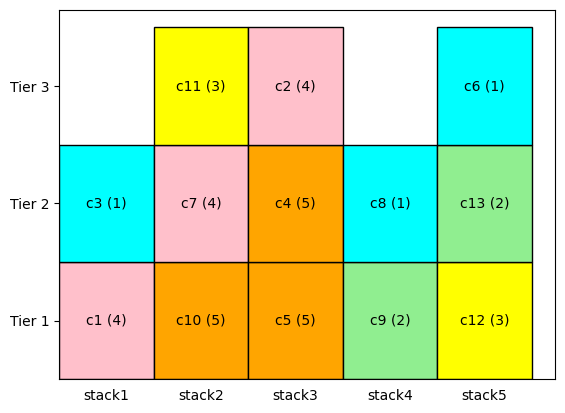

In [27]:
plot_bay(updated_bay)

In [28]:
P

[('stack2', 'stack1'),
 ('stack4', 'stack1'),
 ('stack2', 'stack1'),
 ('stack4', 'stack2'),
 ('stack3', 'stack4'),
 ('stack3', 'stack2'),
 ('stack3', 'stack5'),
 ('stack1', 'stack4'),
 ('stack1', 'stack2'),
 ('stack1', 'stack3'),
 ('stack1', 'stack3'),
 ('stack4', 'stack1')]

In [29]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

bay_copy = bay.copy()

In [30]:
get_container_position(bay, 'c1')

('stack1', 0)

In [31]:
# change

def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            c_prime = m
            M_c.pop(c_prime)
            p_1 = stack_s
        else:
            c_prime = o
            O_c.pop(c_prime)
            p_1 = s_c

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            return [], bay  # Return current pre-processing moves and None to indicate that the operation was not feasible

        
        if s_double_prime is not None:
            bay[s_double_prime].append((c_prime, t_c_prime))
            bay[p_1] = [c for c in bay[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))

    # Move container c to the destination stack and update the bay
    bay[stack_s].append((container_c,t_c))
    bay[s_c] = [c for c in bay[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))

    return P, bay


In [32]:
def preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H):
    print("====================")
    print('algorithm 4 is used')
    print("====================")
    P = []
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    S1 = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    print('S1:', S1)
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and not is_correctly_placed(bay, c[0])}
    S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and get_container_time(bay,c[0])<t_c}

    print('S2:' ,S2)
    
    
    while S1:
        print('==for S1== ')
        c_prime = max(S1, key=S1.get) #top container
        t_c_prime = get_container_time(bay, c_prime) #get time of the container

        # Select s'' for relocation
        excluded_stacks=s_c
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            return [], bay  # Return current pre-processing moves and None to indicate that the operation was not feasible
        
        
        # Relocate container c' to stack s''
        bay[s_double_prime].append((c_prime, t_c_prime))
        bay[s_c] = [c for c in bay[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S1
        P.append((s_c, s_double_prime))
        S1.pop(c_prime)
    
    print("==for c==")
    # Move container c to the highest stack s''' with n (s''') < H
    stack_triple_prime = select_stack_for_c(bay, s_c, H)
    print('available stack for temporary relocation of c: ', stack_triple_prime)

    bay[stack_triple_prime].append((container_c, t_c))
    bay[s_c] = [c for c in bay[s_c] if c[0] != container_c]  # remove container c from the stack
    P.append((s_c, stack_triple_prime))
    
    

    while S2:
        print('==for S2== ')
        c_prime = max(S2, key=S2.get)
        t_c_prime = get_container_time(bay, c_prime)
        # Select s'' for relocation
        excluded_stacks=[s_c,stack_triple_prime]
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
  # Relocate container c' to stack s''
        bay[s_double_prime].append((c_prime, t_c_prime))
        bay[s_c] = [c for c in bay[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S2
        P.append((s_c, s_double_prime))
        S2.pop(c_prime)

    # Move container c to stack s
    bay[s_c].append((container_c, t_c))
    bay[stack_triple_prime] = [c for c in bay[stack_triple_prime] if c[0] != container_c]
    P.append((stack_triple_prime, stack_s))

    return P, bay


# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and stack
container_c = 'c4'
#stack_s = 'stack3'

# Define α, λ1, λ2, H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Test Algorithm 4
P, bay = preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 4 is used
S1: {}
S2: {'c3': 0}
==for c==
available stack for c :  ['stack1', 'stack3', 'stack4', 'stack5']
highest stack for c :  stack3
available stack for temporary relocation of c:  stack3
==for S2== 
available stack for relocation :  ['stack1', 'stack5']
lambda_2 selected stack for relocation :  ['stack5', 'stack1']
s_double_prime:  stack5
The pre-processing moves: [('stack2', 'stack3'), ('stack2', 'stack5'), ('stack3', 'stack1')]
The updated bay: {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2), ('c3', 1)]}


In [33]:
import copy
def local_search_heuristic(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    best_bay={}
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get the containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)

            best_improvement = 0
            best_stack = None
            best_bay = None
            best_moves = []

            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                # Create a copy of the current bay configuration
                #bay_copy = bay.copy()
                bay_copy = copy.deepcopy(bay)

                print('bay copy: ',bay_copy)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, bay_copy = preprocessing_moves_algo3(bay_copy, c, s, α, λ1, λ2, H)
                else:
                    pre_moves, bay_copy = preprocessing_moves_algo4(bay_copy, c, α, λ1, λ2, H)

                if pre_moves is None or bay_copy is None:  # If the move was not feasible, skip to the next iteration
                    continue
                print('pre-moves for ',s,' stack :', pre_moves)
                print('new Bay orientation for ',s,' stack :', bay_copy)
                print('original Bay orientation for ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(bay_copy)
                m_s = len(pre_moves)
                #improvement = current_moves - (α * m_s + new_moves)
                improvement = current_moves -  new_moves

                # Update the best improvement and the best destination stack
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_stack = s
                    best_bay = bay_copy
                    best_moves = pre_moves
                    print("*** improvement achieved***")
                    print("best moves: ", best_moves)
                    print("best bay :", best_bay)
            # If the best improvement is positive, update the bay configuration and the pre-processing moves
            if best_improvement >= 0:
                bay = best_bay
                P += best_moves

    return P,best_bay




In [34]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 5
Containers in  5 time window : {'c4', 'c5', 'c10'}
####################
incorrectly_placed_containers   5 time window : ['c4', 'c10']
Target Container in 5  time window : c4
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
bay:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
algorithm 3 is used
Set O_c: {}
Set M_c: {'c1': 0, 'c2': 1}
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 selected stack for relocation :  ['stack3', 'stack4', 'stack5']
s_double_prime:  stack5
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 select

In [35]:
import pandas as pd
import random

# Define the maximum number of containers per bay, stacks, tiers, and time windows
max_containers = 14
min_containers = 10
stacks = 5
tiers = 4
time_windows = 8

# Initialize list to store the bay data
data = []

# Generate data for 10 bays
for bay in range(1, 11):
    # Determine the number of containers in the bay
    num_containers = random.randint(min_containers, max_containers)
    
    # Create a dictionary to store used tiers for each stack
    used_tiers = {f'stack{i+1}\'': [] for i in range(stacks)}
    
    # Generate data for each container
    for container in range(1, num_containers + 1):
        container_id = f"c{container}'"
        container_location_bay = bay
        # Randomly select a stack ensuring that the selected stack is not full
        while True:
            container_location_stack = f"stack{random.randint(1, stacks)}'"
            if len(used_tiers[container_location_stack]) < tiers:
                break
        # Randomly select a tier ensuring that the selected tier is not used in the selected stack
        while True:
            container_location_tier = random.randint(0, tiers - 1)
            if container_location_tier not in used_tiers[container_location_stack]:
                used_tiers[container_location_stack].append(container_location_tier)
                break
        appointment_time = random.randint(1, time_windows + 1) if random.random() < 0.9 else 9

        # Add the container data to the list
        data.append([
            container_id,
            container_location_bay,
            container_location_stack,
            container_location_tier,
            appointment_time
        ])

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=["container_id", "container_location_bay", "container_location_stack", "container_location_tier", "appointment_time"])

# Write the DataFrame to an Excel file
df.to_excel("bays_data.xlsx", index=False, engine='openpyxl')


In [36]:
df

,container_id,container_location_bay,container_location_stack,container_location_tier,appointment_time
0,c1',1,stack5',1,6
1,c2',1,stack5',3,9
2,c3',1,stack2',2,4
3,c4',1,stack2',0,6
4,c5',1,stack3',3,7
...,...,...,...,...,...
120,c7',10,stack4',1,6
121,c8',10,stack2',3,2
122,c9',10,stack3',2,6
123,c10',10,stack1',1,7


In [49]:
import pandas as pd
import openpyxl
import copy
from openpyxl import Workbook

# function to convert dataframe to bays
def df_to_bays(df):
    bays = {}
    for idx, row in df.iterrows():
        bay = row['container_location_bay']
        stack = row['container_location_stack']
        if bay not in bays:
            bays[bay] = {}
        if stack not in bays[bay]:
            bays[bay][stack] = []
        bays[bay][stack].append((row['container_id'], row['appointment_time']))
    return bays


# function to convert bays to dataframe
def bays_to_df(bays):
    dfs = []
    for bay_id, bay in bays.items():
        df = pd.DataFrame.from_dict(bay, orient='index').reset_index()
        df = df.melt(id_vars=['index'], value_name='Container and Time')
        df[['Container', 'Time']] = pd.DataFrame(df['Container and Time'].tolist(), index=df.index)
        df = df.pivot(index='index', columns='variable', values=['Container', 'Time'])
        df.columns = df.columns.map(''.join)
        df.reset_index(inplace=True)
        df['container_location_bay'] = bay_id
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# 1. Import the Excel file
df = pd.read_excel('bays_data.xlsx')

# 2. Solve local_search_heuristics for each bay
bays = df_to_bays(df)


In [50]:
import pandas as pd

# load the data
df= pd.read_excel('bays_data.xlsx')

# display the data
#print(data)


def df_to_bays(df):
    bays = {}

    # find out the max stack number across all bays
    max_stack = df['container_location_stack'].str.extract('(\d+)').astype(int).max()[0]

    for bay in df['container_location_bay'].unique():
        bays[bay] = {}
        bay_df = df[df['container_location_bay'] == bay]

        for stack in range(1, max_stack + 1):
            stack_name = "stack" + str(stack) + "'"
            if stack_name in bay_df['container_location_stack'].values:
                bays[bay][stack_name] = list(bay_df[bay_df['container_location_stack'] == stack_name][['container_id', 'appointment_time']].to_records(index=False))
            else:
                bays[bay][stack_name] = []

    return bays


In [51]:
bays=df_to_bays(df)


In [52]:
bays

{1: {"stack1'": [("c6'", 1), ("c9'", 1), ("c11'", 1)],
  "stack2'": [("c3'", 4), ("c4'", 6), ("c12'", 8)],
  "stack3'": [("c5'", 7)],
  "stack4'": [("c10'", 9)],
  "stack5'": [("c1'", 6), ("c2'", 9), ("c7'", 7), ("c8'", 9)]},
 2: {"stack1'": [("c3'", 7), ("c7'", 4), ("c11'", 1)],
  "stack2'": [("c5'", 1), ("c6'", 2), ("c8'", 7), ("c10'", 3)],
  "stack3'": [("c4'", 9), ("c12'", 4)],
  "stack4'": [("c1'", 8), ("c13'", 2)],
  "stack5'": [("c2'", 4), ("c9'", 5)]},
 3: {"stack1'": [("c7'", 8), ("c14'", 7)],
  "stack2'": [("c3'", 3), ("c4'", 1), ("c11'", 6), ("c12'", 7)],
  "stack3'": [("c5'", 1), ("c8'", 9)],
  "stack4'": [("c1'", 5), ("c9'", 3)],
  "stack5'": [("c2'", 8), ("c6'", 6), ("c10'", 6), ("c13'", 8)]},
 4: {"stack1'": [("c2'", 6), ("c3'", 3), ("c10'", 3)],
  "stack2'": [("c7'", 3)],
  "stack3'": [("c4'", 6), ("c5'", 3), ("c8'", 9), ("c9'", 9)],
  "stack4'": [("c1'", 9)],
  "stack5'": [("c6'", 7)]},
 5: {"stack1'": [],
  "stack2'": [("c6'", 4), ("c10'", 6), ("c13'", 1)],
  "stack3'

In [53]:
df

,container_id,container_location_bay,container_location_stack,container_location_tier,appointment_time
0,c1',1,stack5',1,6
1,c2',1,stack5',3,9
2,c3',1,stack2',2,4
3,c4',1,stack2',0,6
4,c5',1,stack3',3,7
...,...,...,...,...,...
120,c7',10,stack4',1,6
121,c8',10,stack2',3,2
122,c9',10,stack3',2,6
123,c10',10,stack1',1,7


In [54]:
bay9={"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
  "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
  "stack1'": [("c7'", 5), ("c11'", 2)],
  "stack5'": [("c8'", 7), ("c9'", 5)],
  "stack2'": [("c13'", 8)]}


In [55]:
bay1

NameError: name 'bay1' is not defined

In [84]:
# Define the bay
bay10={"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
  "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
  "stack1'": [("c7'", 5), ("c11'", 2)],
  "stack5'": [("c8'", 7), ("c9'", 5)],
  "stack2'": [("c13'", 8)]}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay10, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 9
Containers in  9 time window : {"c12'", "c1'"}
####################
incorrectly_placed_containers   9 time window : ["c12'"]
Target Container in 9  time window : c12'
___________________________________
checkin stack : stack4'
bay copy:  {"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack1'": [("c7'", 5), ("c11'", 2)], "stack5'": [("c8'", 7), ("c9'", 5)], "stack2'": [("c13'", 8)]}
bay:  {"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack1'": [("c7'", 5), ("c11'", 2)], "stack5'": [("c8'", 7), ("c9'", 5)], "stack2'": [("c13'", 8)]}
algorithm 4 is used
S1: {}
S2: {"c2'": 1, "c4'": 2}
==for c==
available stack for c :  ["stack3'", "stack1'", "stack5'", "stack2'"]
highest stack for c :  stack3'
available stack for temporary relocation of c:  stack3'
==for S2== 
available stack for relocation :  ["stack

In [71]:
bay1

{"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
 "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
 "stack1'": [("c7'", 5), ("c11'", 2)],
 "stack5'": [("c8'", 7), ("c9'", 5)],
 "stack2'": [("c13'", 8)]}

In [72]:
updated_bay

{"stack4'": [("c1'", 9), ("c5'", 8)],
 "stack3'": [("c12'", 9), ("c4'", 7), ("c3'", 1)],
 "stack1'": [("c7'", 5), ("c11'", 2)],
 "stack5'": [("c8'", 7), ("c9'", 5), ("c10'", 4)],
 "stack2'": [("c13'", 8), ("c6'", 7), ("c2'", 6)]}

IndexError: list index out of range

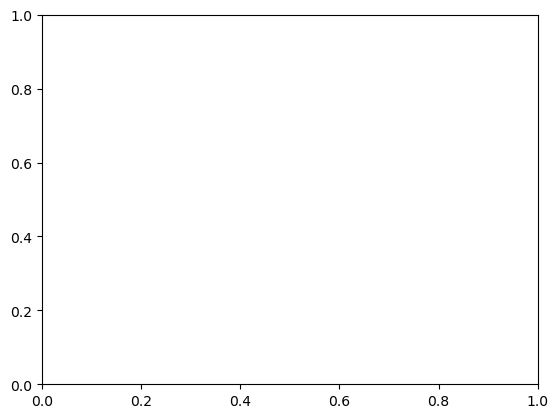

In [64]:
plot_bay(bay1)

In [56]:
import matplotlib.cm as cm

def plot_bays(bays):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    for bay_num, bay in bays.items():
        fig, ax = plt.subplots()

        for i, (stack_name, stack) in enumerate(bay.items()):
            bottom = 0
            for j, (container_id, container_time) in enumerate(stack):
                color_index = list(unique_times).index(container_time)
                ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                bottom += 1

        ax.set_xticks(np.arange(len(bay)))
        ax.set_xticklabels(bay.keys())

        ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
        ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=True)

        ax.set_xlim(left=-0.5)
        plt.title(f'Bay {bay_num}')
        plt.show()


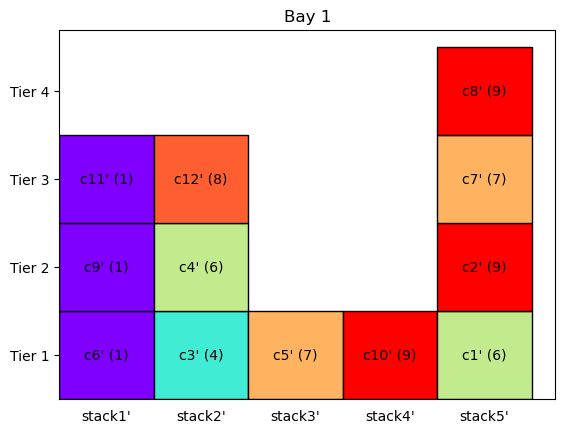

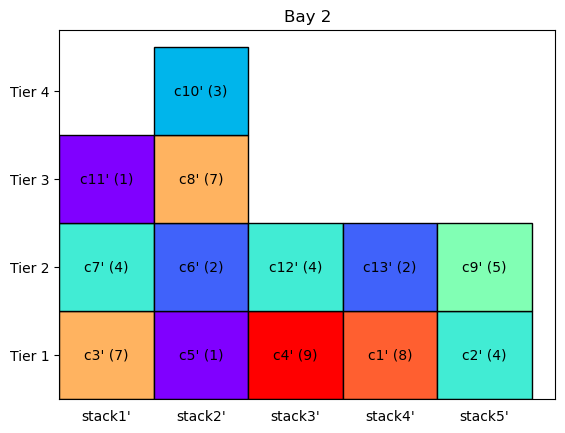

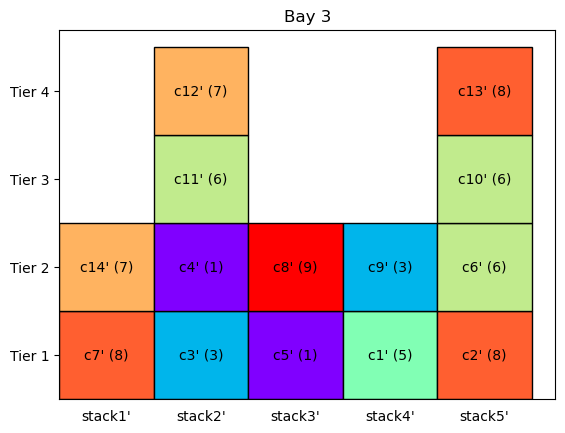

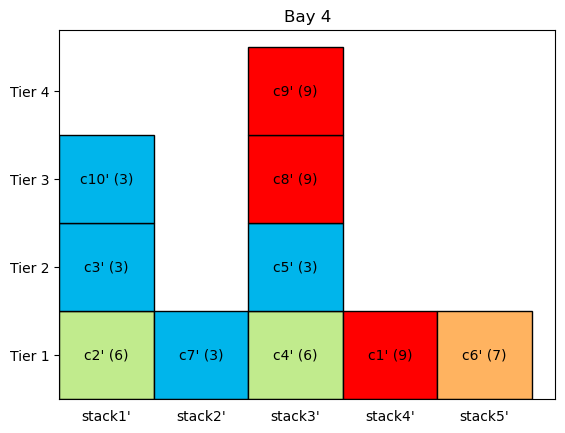

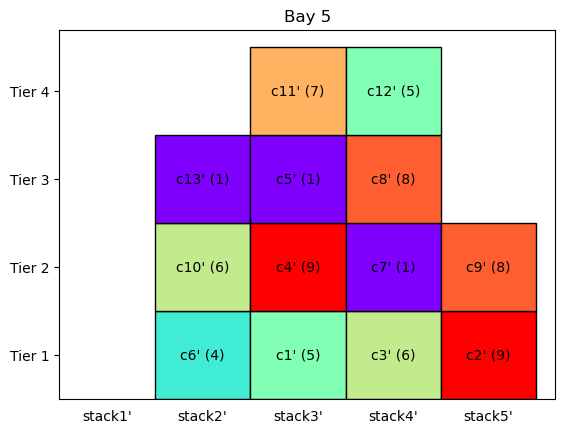

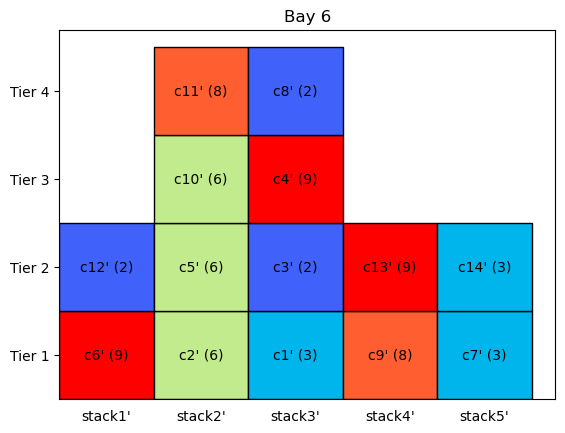

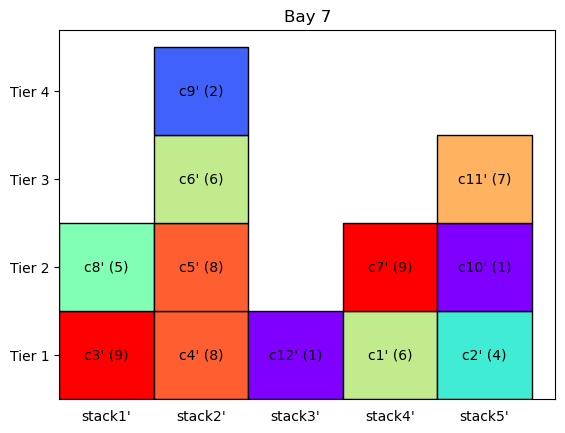

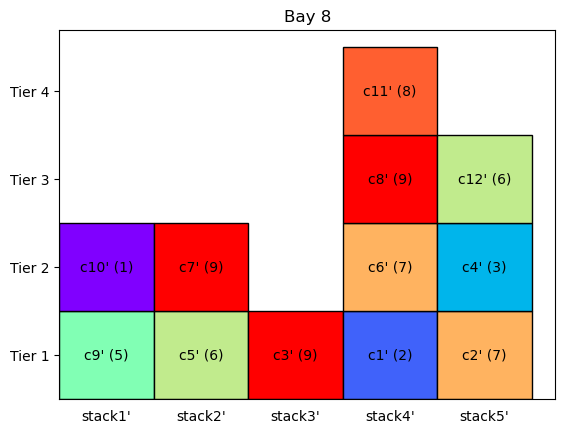

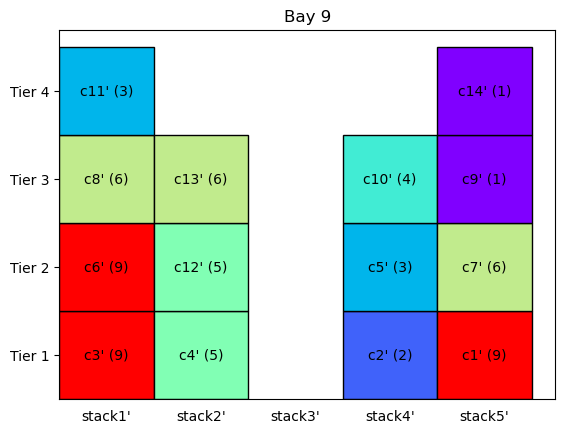

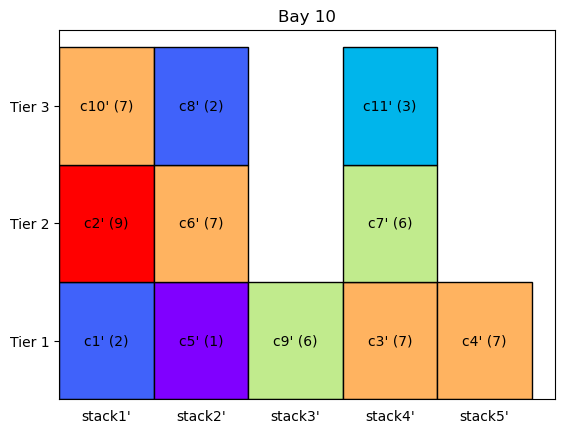

In [57]:
plot_bays(bays)

In [58]:
# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

def solve_all_bays(bays, α, λ1, λ2, H):
    all_moves = {}
    all_bays = {}

    # Loop over each bay in the dictionary
    for bay_num, bay in bays.items():
        print(f"*** Starting to solve bay {bay_num} ***")
        moves, new_bay = local_search_heuristic(bay, α, λ1, λ2, H)
        
        # Store the moves and the new bay configuration in the dictionaries
        all_moves[bay_num] = moves
        all_bays[bay_num] = new_bay

    return all_moves, all_bays

# α, λ1, λ2, and H are parameters of your heuristic, replace them with their actual values
all_moves, all_bays = solve_all_bays(bays, α, λ1, λ2, H)


*** Starting to solve bay 1 ***
Time Windows or Time Frames : 9
Containers in  9 time window : {"c8'", "c2'", "c10'"}
####################
incorrectly_placed_containers   9 time window : ["c8'", "c2'"]
Target Container in 9  time window : c2'
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [("c6'", 1), ("c9'", 1), ("c11'", 1)], "stack2'": [("c3'", 4), ("c4'", 6), ("c12'", 8)], "stack3'": [("c5'", 7)], "stack4'": [("c10'", 9)], "stack5'": [("c1'", 6), ("c2'", 9), ("c7'", 7), ("c8'", 9)]}
bay:  {"stack1'": [("c6'", 1), ("c9'", 1), ("c11'", 1)], "stack2'": [("c3'", 4), ("c4'", 6), ("c12'", 8)], "stack3'": [("c5'", 7)], "stack4'": [("c10'", 9)], "stack5'": [("c1'", 6), ("c2'", 9), ("c7'", 7), ("c8'", 9)]}
algorithm 3 is used
Set O_c: {"c7'": 2, "c8'": 3}
Set M_c: {"c6'": 0, "c9'": 1, "c11'": 2}
available stack for relocation :  ["stack2'", "stack3'", "stack4'"]
lambda_2 selected stack for relocation :  ["stack2'", "stack3'", "stack4'"]
s_double_prime:  st

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
all_moves

In [59]:
all_bays

NameError: name 'all_bays' is not defined

In [60]:
plot_bays(all_bays)

NameError: name 'all_bays' is not defined

In [61]:
import pandas as pd

def export_to_excel(all_bays, file_name='bays.xlsx'):
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        for bay_id, bay in all_bays.items():
            # Convert each bay to a DataFrame
            df = pd.DataFrame.from_dict(bay, orient='index')

            # Write each DataFrame to a separate sheet in the Excel file
            df.to_excel(writer, sheet_name=f'Bay {bay_id}')

    print(f'Excel file saved as {file_name}')


In [62]:
export_to_excel(all_bays, 'updated_bays.xlsx')


NameError: name 'all_bays' is not defined

In [63]:
import pandas as pd

def export_to_excel(all_bays, file_name='bays.xlsx'):
    data = []
    for bay_id, bay in all_bays.items():
        for stack_id, stack in bay.items():
            for tier, container_info in enumerate(stack, 1):  # Assuming tier starts from 1
                container_id, time_window = container_info
                data.append([bay_id, stack_id, tier, container_id, time_window])
    df = pd.DataFrame(data, columns=['Bay', 'Stack', 'Tier', 'Container', 'Time Window'])
    df.to_excel(file_name, index=False)
    print(f'Excel file saved as {file_name}')

export_to_excel(all_bays, 'updated_bays.xlsx')


NameError: name 'all_bays' is not defined

In [64]:
all_moves

NameError: name 'all_moves' is not defined

In [65]:
import pandas as pd

def export_moves_to_excel(all_moves, file_name='moves.xlsx'):
    data = []
    for bay_id, moves in all_moves.items():
        for move in moves:
            source_stack, destination_stack = move
            data.append([bay_id, source_stack, destination_stack])
    df = pd.DataFrame(data, columns=['Bay', 'Source Stack', 'Destination Stack'])
    df.to_excel(file_name, index=False)
    print(f'Excel file saved as {file_name}')

export_moves_to_excel(all_moves, 'pre_processing_moves.xlsx')


NameError: name 'all_moves' is not defined

In [66]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, (stack_name, stack) in enumerate(bay.items()):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(bay)))
            ax.set_xticklabels(bay.keys())

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [67]:
plot_bays(bays, 'bays_plots.pdf')


In [68]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, (stack_name, stack) in enumerate(bay.items()):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(bay)))
            ax.set_xticklabels(bay.keys())

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location in Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [69]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            # Ensure that all stacks are displayed
            for i in range(5):
                stack_name = f'stack{i+1}'
                if stack_name not in bay:
                    bay[stack_name] = []  # initialize an empty list for the stack

            for i, (stack_name, stack) in enumerate(sorted(bay.items())):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(5))  # there are 5 stacks
            ax.set_xticklabels([f'stack{i+1}' for i in range(5)])

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location for Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [70]:
plot_bays(bays, 'initial_bays_plots1.pdf')

In [71]:
plot_bays_final(all_bays, 'final_bays_plots.pdf')

NameError: name 'plot_bays_final' is not defined

In [82]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    # Define a fixed set of stack names
    stack_names = [f"stack{i}'" for i in range(1, 6)]

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, stack_name in enumerate(stack_names):
                stack = bay.get(stack_name, [])  # Use empty list if stack is not in the bay

                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(stack_names)))
            ax.set_xticklabels(stack_names)

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location for Bay {bay_num}')

            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [79]:
bays

{1: {"stack1'": [("c6'", 1), ("c9'", 1), ("c11'", 1)],
  "stack2'": [("c3'", 4), ("c4'", 6), ("c12'", 8)],
  "stack3'": [("c5'", 7)],
  "stack4'": [("c10'", 9)],
  "stack5'": [("c1'", 6), ("c2'", 9), ("c7'", 7), ("c8'", 9)],
  'stack1': [],
  'stack2': [],
  'stack3': [],
  'stack4': [],
  'stack5': []},
 2: {"stack1'": [("c3'", 7), ("c7'", 4), ("c11'", 1)],
  "stack2'": [("c5'", 1), ("c6'", 2), ("c8'", 7), ("c10'", 3)],
  "stack3'": [("c4'", 9), ("c12'", 4)],
  "stack4'": [("c1'", 8), ("c13'", 2)],
  "stack5'": [("c2'", 4), ("c9'", 5)],
  'stack1': [],
  'stack2': [],
  'stack3': [],
  'stack4': [],
  'stack5': []},
 3: {"stack1'": [("c7'", 8), ("c14'", 7)],
  "stack2'": [("c3'", 3), ("c4'", 1), ("c11'", 6), ("c12'", 7)],
  "stack3'": [("c5'", 1), ("c8'", 9)],
  "stack4'": [("c1'", 5), ("c9'", 3)],
  "stack5'": [("c2'", 8), ("c6'", 6), ("c10'", 6), ("c13'", 8)],
  'stack1': [],
  'stack2': [],
  'stack3': [],
  'stack4': [],
  'stack5': []},
 4: {"stack1'": [("c2'", 6), ("c3'", 3), ("

In [80]:
def plot_bays(bays, H, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    # Define a fixed set of stack names
    stack_names = [f"stack{i}'" for i in range(1, 6)]

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, stack_name in enumerate(stack_names):
                stack = bay.get(stack_name, [])  # Use empty list if stack is not in the bay

                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(stack_names)))
            ax.set_xticklabels(stack_names)

            # Set y-ticks and y-ticklabels to reflect all tiers up to H
            ax.set_yticks(np.arange(H) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(H)])

            # Set y-axis limits
            ax.set_ylim(0, H)

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location for Bay {bay_num}')

            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [83]:
plot_bays(bays, 'initial_bays_plots_2.pdf')

In [7]:
bay2={"stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [133]:
bay2

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [134]:
calculate_q_values(bay2)

{"stack1'": [],
 "stack2'": [1, 3],
 "stack3'": [1, 3, 1],
 "stack4'": [1],
 "stack5'": [1, 3, 3, 3]}

In [135]:
calculate_q_values(bay2)

{"stack1'": [],
 "stack2'": [1, 3],
 "stack3'": [1, 3, 1],
 "stack4'": [1],
 "stack5'": [1, 3, 3, 3]}

In [136]:
calculate_expected_relocation_moves(bay2)

5

In [17]:
calculate_expected_moves(bay2,"stack1'")

0

In [19]:
calculate_u_c(bay2,"c1'")

inf

In [ ]:
def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            c_prime = m
            M_c.pop(c_prime)
            p_1 = stack_s
        else:
            c_prime = o
            O_c.pop(c_prime)
            p_1 = s_c

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [], bay
        
        if s_double_prime is not None:
            bay_copy[s_double_prime].append((c_prime, t_c_prime))
            bay_copy[p_1] = [c for c in bay_copy[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))

    # Move container c to the destination stack and update the bay
    bay_copy[stack_s].append((container_c,t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))

    return P, bay_copy
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }
# Define the container and destination stack
container_c = "c4'"
stack_s = "stack1'"

# Define α, λ1, λ2, H3
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply Algorithm 3
P, updated_bay = preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)
